In [2]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import fisher_exact
import shelve
import pickle
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from PIL import Image
from scipy.interpolate import BSpline, make_interp_spline, interp1d
import csv
from dfply import *
import itertools
import os
import logging
from sys import getsizeof
import sklearn
import time
from sklearn.metrics import roc_auc_score
from catboost import Pool, cv
import xgboost
import catboost
import scipy.stats as st

import importlib
from joblib import Parallel, delayed
from joblib import parallel_backend

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
#from statsmodels.tsa.vector_ar.var_model import VARY
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, pacf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
warnings.filterwarnings("ignore")
import scipy
import datetime

from joblib import Parallel, delayed

import pyarrow
import concurrent.futures
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from itertools import product

import statsmodels

In [3]:
import myccm
importlib.reload(myccm)

pyunicorn: Package netCDF4 could not be loaded. Some functionality in class Data might not be available!
pyunicorn: Package netCDF4 could not be loaded. Some functionality in class NetCDFDictionary might not be available!


<module 'myccm' from '/home/hoyinchan/code/AKI_CDM_PY/timeseries/myccm.py'>

In [5]:
sites = ['MCRI', 'IUR', 'MCW', 'UIOWA', 'UMHC', 'UNMC', 'UofU', 'UPITT', 'UTHSCSA', 'KUMC', 'UTSW']
#sites = ['KUMC', 'UTSW', 'MCW', 'UofU', 'UIOWA', 'UMHC', 'UPITT', 'UTHSCSA', 'UNMC']
datafolder = '/home/hoyinchan/blue/Data/data2022/'

In [6]:
# loincs_cofounder_potassium = ['2157-6', #creatine kinase
#                               '1920-8', #AST      
#                               '2532-0', #LDH
#                               '4542-7', #Haptoglobin 
#                               '3084-1'] #uric acid
#bp_cofounder_potassium = ['DIASTOLIC','SYSTOLIC']
#loincs_potassium = ['2823-3', '2160-0']

loincs_cofounder_potassium = ['2157-6', # 'creatineKinase(HK)',
                               'LG6033-7', # 'AST(HK)',      
                               '2532-0',  # 'LDH(HK)',
                               'LG44861-9', # 'Haptoglobin(HK)', 
                               'LG49755-8'] # 'uricAcid(HK)'}
bp_cofounder_potassium = ['DIASTOLIC','SYSTOLIC']
loincs_potassium = ['LG49936-4', 'LG6657-3']

loincs_dependents = ['LG49864-8', #Ca
                     'LG11363-5', #Na
                     'LG6657-3'] #K, $sCr

In [5]:
# import myccm
# labXs = list()
# for site in sites:
#     try:
#         print(site)
# #        myccmX = myccm.myccm()
# #        myccmX.get_onsetdata(site=site)                
# #        myccmX.get_data(site=site)      
# #        myccmX.get_vitaldata(site=site)     
# #        labt = myccmX.labX
# #        labt = pd.read_csv(datafolder+site+'/raw/AKI_VITAL.csv')
#         labt['site'] = site
#         labXs.append(labt)
#     except:
#        print('not working')
#     # for loinc1 in loincs_cofounder_potassium:
#     #     for loinc2 in loincs_potassium:
#     #         try:
#     #             generate_data_for_pco(loinc1, loinc2)
#     #         except:
#     #             pass

In [6]:
def process_site(site):
    try:
        print(site)
        myccmX = myccm.myccm()
        myccmX.get_onsetdata(site=site)                
        myccmX.get_data(loincs_cofounder_potassium, loincs_potassium, loincs_dependents, site=site)      
#        labt = myccmX.labX

        # myccmX.get_vitaldata(site=site)
        
        labt = myccmX.labV
        labt['site'] = site
        
        return labt    
    except Exception as e: 
        print('not working for site:', site, 'Error:', e)
        return None

def parallel_processing(sites):
    labXs = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=9) as executor:
        results = executor.map(process_site, sites)        
#        for result in results:
#            labXs.extend(result)
    return results

labXs = parallel_processing(sites)

labX2 = list(labXs)
labX3 = [x for x in labX2 if isinstance(x, pd.DataFrame)]
labX4 = pd.concat(labX3)

labX4['PATID'] = labX4['PATID'].astype(str)
labX4['ENCOUNTERID'] = labX4['ENCOUNTERID'].astype(str)
labX4['ID'] = labX4['PATID']+'_'+labX4['ENCOUNTERID']+'_'+labX4['site']
labX4['DAYS_SINCE_ADMIT'] = labX4['DAYS_SINCE_ADMIT'].astype(int)
labX4.to_parquet(datafolder+'alllab.parquet')
#labX4.to_parquet(datafolder+'allvital.parquet')

UTSWKUMCUIOWAMCWUPITTUofUUMHC





UTHSCSAUNMC




In [7]:
labV = pd.read_parquet(datafolder+'allvital.parquet')
labX = pd.read_parquet(datafolder+'alllab.parquet')
labV = labV[['ID','DAYS_SINCE_ADMIT','DIASTOLIC','SYSTOLIC', 'site']]
labV = pd.melt(labV, id_vars=['ID', 'DAYS_SINCE_ADMIT', 'site'], value_vars=['DIASTOLIC', 'SYSTOLIC'])
labV = labV.rename({'variable':'LAB_LOINC', 'value':'RESULT_NUM' },axis=1)
labX = pd.concat([labX, labV])

In [ ]:
#for loinc1 in loincs_cofounder_potassium:
for loinc1 in loincs_cofounder_potassium+bp_cofounder_potassium:
    for loinc2 in loincs_potassium:
        try:
            gen_files(loinc1, loinc2)
        except Exception as e: 
            print('not working for site:', loinc1, loinc2, 'Error:', e)

In [ ]:
def gen_files(loinc1, loinc2, l=10):
#    labX = pd.read_parquet(datafolder+'alllab.parquet')
    outputlab = labX[labX['LAB_LOINC'].str.contains('|'.join([loinc1,loinc2])).fillna(False)]

    outputlab = outputlab[['ID','DAYS_SINCE_ADMIT','RESULT_NUM','LAB_LOINC', 'site']]
    outputlab = outputlab.groupby(['ID','DAYS_SINCE_ADMIT','LAB_LOINC', 'site']).mean().reset_index()

    def get_residue(xx):
        xxp = xx.pivot(index='DAYS_SINCE_ADMIT', columns='LAB_LOINC', values='RESULT_NUM')
        xxp = xxp.reindex(list(range(xxp.index.min(),xxp.index.max()+1)))
        xxp = xxp.interpolate(limit_area='inside').dropna()
        try:
            model = sm.OLS(xxp[loinc2], xxp[loinc1])
            res = model.fit()
            xxp['res'] = res.resid
            return xxp
        except:
            return None
        #cadf = ts.adfuller(res.resid)

    xxx = outputlab.groupby(['ID','LAB_LOINC'])['DAYS_SINCE_ADMIT'].count().reset_index().pivot(index='ID', columns='LAB_LOINC', values='DAYS_SINCE_ADMIT').dropna()
    xxx = xxx[(xxx[loinc1]>=l)&(xxx[loinc2]>=l)]

    outputlab2 = xxx.merge(outputlab, on='ID', how='left')
    outputlab2 = outputlab2[outputlab.columns]

    outputlab3 = outputlab2.groupby(['ID','site']).apply(get_residue).reset_index().dropna()
    outputlab3 = outputlab3.rename({0:'res'},axis=1)

    outputlab3['ID'] = pd.factorize(outputlab3['ID'])[0]

    datafolder = '/home/hoyinchan/blue/Data/data2022/'
    print(loinc1, loinc2, len(outputlab3['ID'].unique()))
    outputlab3.to_parquet(datafolder+'outputlab'+loinc1+loinc2+'.parquet')

In [10]:
loinc1 = 'LG6033-7'
loinc2 = 'LG6657-3'
l = 10

In [11]:
pdfs = list()
for loinc1 in loincs_cofounder_potassium+bp_cofounder_potassium:
    for loinc2 in loincs_potassium:
        try:
            outputlab = labX[labX['LAB_LOINC'].str.contains('|'.join([loinc1,loinc2])).fillna(False)]

            outputlab = outputlab[['ID','DAYS_SINCE_ADMIT','RESULT_NUM','LAB_LOINC', 'site']]
            outputlab = outputlab.groupby(['ID','DAYS_SINCE_ADMIT','LAB_LOINC', 'site']).mean().reset_index()
            xxx = outputlab.groupby(['ID','LAB_LOINC'])['DAYS_SINCE_ADMIT'].count().reset_index().pivot(index='ID', columns='LAB_LOINC', values='DAYS_SINCE_ADMIT').dropna()
            xxx = xxx[(xxx[loinc1]>=l)&(xxx[loinc2]>=l)]

            outputlab2 = xxx.merge(outputlab, on='ID', how='left')
            outputlab2 = outputlab2[outputlab.columns]

            outputlab2 = outputlab2.pivot(index=['ID', 'DAYS_SINCE_ADMIT'], columns='LAB_LOINC', values='RESULT_NUM').reset_index()
            #outputlab2 = outputlab2.reindex(list(range(xxp.index.min(),xxp.index.max()+1)))

            outputlab3 = outputlab2.dropna()

            xxxc = outputlab3.groupby('ID').count().reset_index()
            xxxc = xxxc[xxxc['DAYS_SINCE_ADMIT']>=10]
            xxxc['n'] = xxxc['DAYS_SINCE_ADMIT']
            
            outputlab3 = outputlab3.merge(xxxc[['ID', 'n']], how='inner')

            def pearson_sub(df):
                c = list(df.columns)
                c.remove('ID')
                c.remove('DAYS_SINCE_ADMIT')
                return scipy.stats.pearsonr(df[c[0]], df[c[1]])[0]

            pdf = outputlab3.groupby(['ID','n']).apply(pearson_sub).reset_index()
            pdf['loinc1'] = loinc1
            pdf['loinc2'] = loinc2
            pdfs.append(pdf)
        except:
            pass
pdfs = pd.concat(pdfs)

In [12]:
pdfs = pdfs.rename({0:'pearson'},axis=1)

In [13]:
#pdfs.to_parquet(datafolder+'outputlab_Pearson.parquet')

In [14]:
pdfs = pd.read_parquet(datafolder+'outputlab_Pearson.parquet')

In [15]:
plist = list()
def calcualte_raw_p(labX, loinc1, loinc2):
    dflist = list()    
    outputlabX = labX[labX['LAB_LOINC'].str.contains('|'.join([loinc1,loinc2])).fillna(False)]    
    
    myplist = list()
    for shift in range(-7,8):
        outputlab = outputlabX[['ID','DAYS_SINCE_ADMIT','RESULT_NUM','LAB_LOINC', 'site']].copy()     

        outputlab.loc[outputlab['LAB_LOINC'] == loinc2, 'DAYS_SINCE_ADMIT'] -= shift

        outputlab = outputlab.groupby(['ID','DAYS_SINCE_ADMIT','LAB_LOINC', 'site']).mean().reset_index()
        xxx = outputlab.groupby(['ID','LAB_LOINC'])['DAYS_SINCE_ADMIT'].count().reset_index().pivot(index='ID', columns='LAB_LOINC', values='DAYS_SINCE_ADMIT').dropna()
        xxx = xxx[(xxx[loinc1]>=l)&(xxx[loinc2]>=l)]

        outputlab2 = xxx.merge(outputlab, on='ID', how='left')
        outputlab2 = outputlab2[outputlab.columns]

        outputlab2 = outputlab2.pivot(index=['ID', 'DAYS_SINCE_ADMIT'], columns='LAB_LOINC', values='RESULT_NUM').reset_index()
        #outputlab2 = outputlab2.reindex(list(range(xxp.index.min(),xxp.index.max()+1)))

        outputlab3 = outputlab2.dropna()

        xxxc = outputlab3.groupby('ID').count().reset_index()
        xxxc = xxxc[xxxc['DAYS_SINCE_ADMIT']>=10]
        xxxc['n'] = xxxc['DAYS_SINCE_ADMIT']

        outputlab3 = outputlab3.merge(xxxc[['ID', 'n']], how='inner')
        outputlab3['shift']=shift
        dflist.append(outputlab3)
        
        pear = scipy.stats.pearsonr(outputlab3[loinc1], outputlab3[loinc2])
        myplist.append([loinc1, loinc2, shift, pear[0], pear[1]])
        
    dflist = pd.concat(dflist)
    dflist.to_parquet(datafolder+''+'xtllr_'+loinc1.replace("-",'')+loinc2.replace("-",'')+'.parquet')
    return myplist

for loinc1 in loincs_cofounder_potassium+bp_cofounder_potassium:
    for loinc2 in loincs_potassium:
        try:
            print(loinc1, loinc2)
            plist.append(calcualte_raw_p(labX, loinc1, loinc2))
            print('Done: ', loinc1, loinc2)            
        except:
            pass        
#plist=pd.DataFrame(plist)

2157-6 LG49936-4
Done:  2157-6 LG49936-4
2157-6 LG6657-3
Done:  2157-6 LG6657-3
LG6033-7 LG49936-4
Done:  LG6033-7 LG49936-4
LG6033-7 LG6657-3
Done:  LG6033-7 LG6657-3
2532-0 LG49936-4
Done:  2532-0 LG49936-4
2532-0 LG6657-3
Done:  2532-0 LG6657-3
LG44861-9 LG49936-4
Done:  LG44861-9 LG49936-4
LG44861-9 LG6657-3
Done:  LG44861-9 LG6657-3
LG49755-8 LG49936-4
Done:  LG49755-8 LG49936-4
LG49755-8 LG6657-3
Done:  LG49755-8 LG6657-3
DIASTOLIC LG49936-4
Done:  DIASTOLIC LG49936-4
DIASTOLIC LG6657-3
Done:  DIASTOLIC LG6657-3
SYSTOLIC LG49936-4
Done:  SYSTOLIC LG49936-4
SYSTOLIC LG6657-3
Done:  SYSTOLIC LG6657-3


In [19]:
#plist_tmp = plist.copy()
plist = plist_tmp.copy()

In [20]:
plist = [item for sublist in plist for item in sublist]
plist=pd.DataFrame(plist)

In [21]:
plist[0].unique()

array(['2157-6', 'LG6033-7', '2532-0', 'LG44861-9', 'LG49755-8',
       'DIASTOLIC', 'SYSTOLIC'], dtype=object)

In [22]:
plist.columns = ['loinc1', 'loinc2', 'shift', 'rho', 'pvalue']

In [23]:
plist.to_parquet(datafolder+''+'plist.parquet')

In [24]:
plist = pd.read_parquet(datafolder+''+'plist.parquet')

In [25]:
plist['loinc1'].unique()

array(['2157-6', 'LG6033-7', '2532-0', 'LG44861-9', 'LG49755-8',
       'DIASTOLIC', 'SYSTOLIC'], dtype=object)

In [26]:
# loincs_cofounder_potassium_names = {
#     '2157-6': 'creatine kinase',
#     '1920-8': 'AST',
#     '2532-0': 'LDH',
#     '4542-7': 'Haptoglobin',
#     '3084-1': 'uric acid'
# }

loincs_cofounder_potassium_names = {'2157-6': 'creatineKinase',
                               'LG6033-7': 'AST',      
                               '2532-0': 'LDH',
                               'LG44861-9': 'Haptoglobin', 
                               'LG49755-8': 'uricAcid'}

bp_cofounder_potassium_names = {
    'DIASTOLIC': 'Diastolic Blood Pressure',
    'SYSTOLIC': 'Systolic Blood Pressure'
}

# loincs_potassium_names = {
#     '2823-3': 'Potassium',
#     '2160-0': 'Scr'
# }

loincs_potassium_names = {
    'LG49936-4': 'Potassium',
    'LG6657-3': 'Scr'
}


# Combine all dictionaries into one for simplicity
all_mappings = {**loincs_cofounder_potassium_names, **bp_cofounder_potassium_names, **loincs_potassium_names}

In [27]:
# Translate loinc1 and loinc2 using the mapping
plist['loinc1'] = plist['loinc1'].replace(all_mappings)
plist['loinc2'] = plist['loinc2'].replace(all_mappings)

In [28]:
selectx = list(loincs_cofounder_potassium_names.values())
selectx.remove('Haptoglobin')
selectx = '|'.join(selectx)
plist = plist[plist['loinc1'].str.contains(selectx)]
plist['pvalue_adj'] = statsmodels.stats.multitest.multipletests(plist['pvalue'])[1]

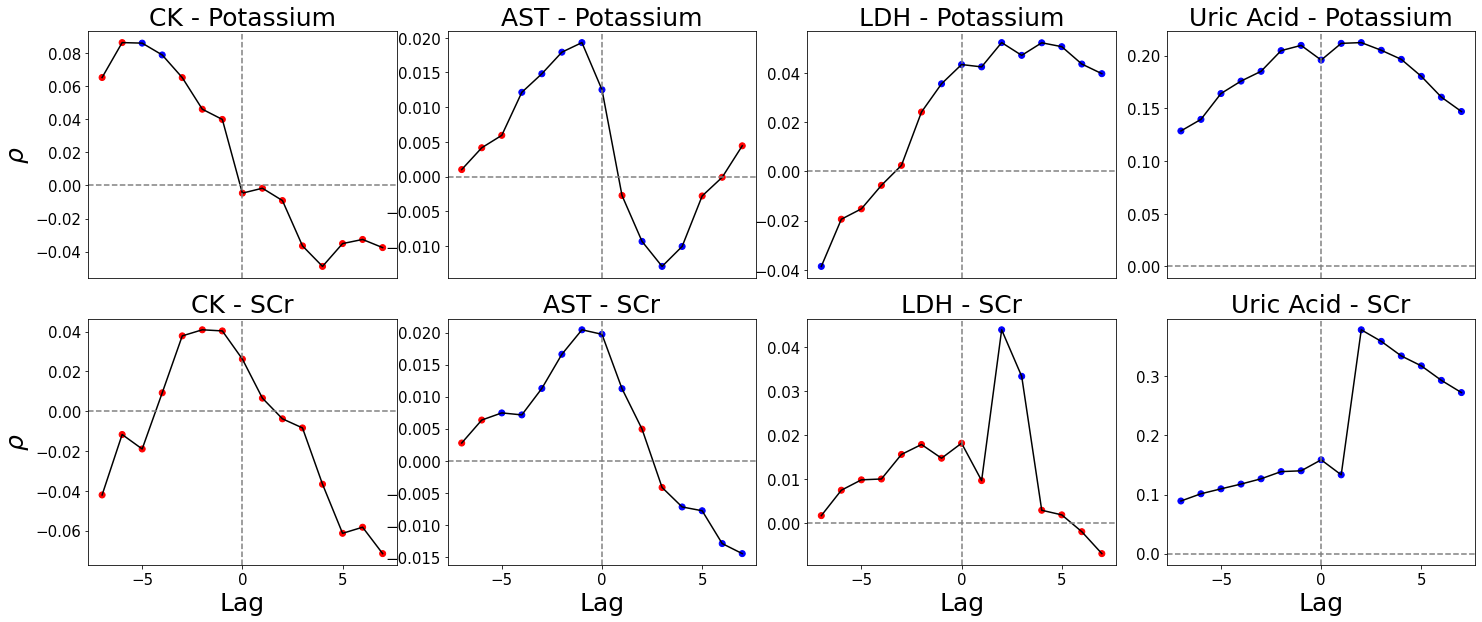

In [29]:
# Set up the 2x4 subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
fig.tight_layout(w_pad=2.0, h_pad=2.0)

unique_loinc1_values = plist['loinc1'].unique()

for i, loinc1_value in enumerate(unique_loinc1_values):
    # Filter data for current loinc1_value and 'Potassium'
    potassium_data = plist[(plist['loinc1'] == loinc1_value) & (plist['loinc2'] == 'Potassium')]
    potassium_colors = ['red' if p >= 0.05 else 'blue' for p in potassium_data['pvalue_adj']]
    
    # Filter data for current loinc1_value and 'SCr'
    scr_data = plist[(plist['loinc1'] == loinc1_value) & (plist['loinc2'] == 'Scr')]
    scr_colors = ['red' if p >= 0.05 else 'blue' for p in scr_data['pvalue_adj']]

    # Plot line and scatter for 'Potassium' on top row
    axs[0, i].plot(potassium_data['shift'], potassium_data['rho'], linestyle='-', color='black')  # line connecting dots
    axs[0, i].scatter(potassium_data['shift'], potassium_data['rho'], color=potassium_colors)
    axs[0, i].set_title(f"{loinc1_value.replace('creatineKinase', 'CK').replace('uricAcid', 'Uric Acid')} - Potassium", fontsize=25)
    if i == 0:
        axs[0, i].set_ylabel(r'$\rho$', fontsize=25)
    else:
        axs[0, i].set_ylabel("")
    axs[0, i].set_xticks([])
    axs[0, i].axvline(0, color='gray', linestyle='--')
    axs[0, i].axhline(0, color='gray', linestyle='--')

    # Plot line and scatter for 'SCr' on bottom row
    axs[1, i].plot(scr_data['shift'], scr_data['rho'], linestyle='-', color='black')  # line connecting dots
    axs[1, i].scatter(scr_data['shift'], scr_data['rho'], color=scr_colors)
    axs[1, i].set_title(f"{loinc1_value.replace('creatineKinase', 'CK').replace('uricAcid', 'Uric Acid')} - SCr", fontsize=25)
    axs[1, i].set_xlabel("Lag", fontsize=25)
    if i == 0:
        axs[1, i].set_ylabel(r'$\rho$', fontsize=25)
    else:
        axs[1, i].set_ylabel("")
    axs[1, i].axvline(0, color='gray', linestyle='--')
    axs[1, i].axhline(0, color='gray', linestyle='--')
    
    axs[0, i].tick_params(axis='both', which='major', labelsize=15)
    axs[1, i].tick_params(axis='both', which='major', labelsize=15)

plt.savefig('lagged_correlation.svg', bbox_inches='tight')
plt.show()

In [30]:
plist2 = pd.DataFrame(plist2)

NameError: name 'plist2' is not defined

In [ ]:
plist2.columns = ['loinc1', 'loinc2', 'shift', 'rho', 'pvalue']

In [ ]:
plt.plot(plist2['shift'],plist2['rho'])